In [6]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import simpson, odeint
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator

In [7]:
common_settings = {
'perturbations_verbose':0,
'background_verbose':0,
'output':'mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':300,
'z_max_pk':1000,
'format':'class'
}

chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
chiCDM.set({
'omega_cdm':0.11,
'f_chi':1.e-10 ,
'acs_chi':1.e-7,
'cs2_peak_chi':1./3.,
# 'N_ur': 2.0328,
# 'N_ncdm':1,
# 'm_ncdm':0.1, #0.1 means 0.8%

})

chiCDM.compute()

In [8]:
from scipy.interpolate import interp1d
fact=(2*np.pi)**3

kk = np.logspace(-5,np.log10(200),500) # k in h/Mpc
Pkchi = [] # P(k) in (Mpc/h)**3
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

lowz=0.

for k in kk:
    Pkchi.append(chiCDM.pk_lin(k*h,lowz)*h**3) # function .pk(k,z)
Pkchi=np.array(Pkchi)

Pchi_int = interp1d(kk, Pkchi, fill_value='extrapolate')


# plt.figure(figsize=(4,3), dpi=130)
# plt.xscale('log');plt.yscale('log');
# plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
# plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
# plt.plot(kk,Pkchi,'r-',label=r'ChiCDM')
# plt.plot(kk[:-1]+1.e-3,Pchi_int(kk[:-1]+1.e-3),'c-',label=r'txt')
# plt.legend()
# plt.show()

----
chi quantities

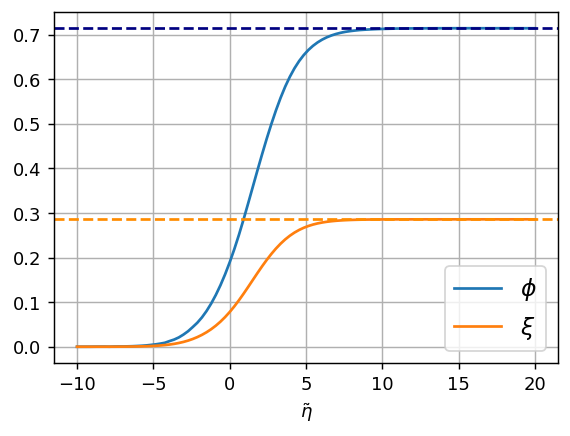

In [9]:
## START WITH g AND h 
def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
# Initial conditions
w0 = [0.,0.]
t = np.linspace(-10,30, 100)
sol = odeint(gh_system, w0, t)
g_int = interp1d(t, sol[:, 0], fill_value='extrapolate')
h_int = interp1d(t, sol[:, 1], fill_value='extrapolate')

def phieq(y,t):
    phi, phi_prime = y
    g= g_int(t); h= h_int(t) 
    gprime = h - g
    hprime = 3/2 *(1-h)-3/2*np.exp(-t)*g
    phi_double_prime = (-9/2)*phi_prime - (5 + (3/2)*np.exp(-t))*phi + (15/14) + (5/2)*g_int(t)*h + gprime*h + g*hprime
    return [phi_prime, phi_double_prime]

def xieq(y,t):
    xi, xi_prime = y
    h= h_int(t) 
    xi_double_prime = (-9/2)*xi_prime - (5 + (3/2)*np.exp(-t))*xi + (3/7) + h*h
    return [xi_prime,xi_double_prime]

t = np.linspace(-10,20, 100)
sol = odeint(phieq,[0.,0.], t, atol=1.e-3, rtol=1.e-3)
phi_int = interp1d(t, sol[:, 0])
sol = odeint(xieq,[0.,0.], t)
xi_int = interp1d(t, sol[:, 0])
plt.figure(figsize=(5,3.5), dpi=130)
plt.plot(t, phi_int(t), label=r'$\phi$')
plt.plot(t, xi_int(t), label=r'$\xi$')
plt.axhline(y=5/7, color='navy', linestyle='--')
plt.axhline(y=2/7, color='darkorange', linestyle='--')
plt.xlabel(r'$\tilde \eta$')
plt.legend(fontsize=13)
plt.grid(True)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/phi-xi.pdf',bbox_inches='tight')
plt.show()


In [11]:
from multiprocessing import Pool
# Construct interpolators for phi, xi
z_eval = 0
Nks = 20
kk = np.logspace(-3,1,Nks)
phigrid = np.zeros((Nks,Nks,Nks))

def eval_phi_xi(ks):
    k, k1, k2 = ks
    te = 3 - 2*np.log(k/0.1) #tildeeta is 2 on k=0.1, my choice
    tsol = np.linspace(-10,te, 100)
    def phieq(y,t):
        phi, phi_prime = y
        g= g_int(t - 2*np.log(k1/0.1)); h= h_int(t - 2*np.log(k2/0.1)) 
        gprime = h - g
        hprime = 3/2 *(1-h)-3/2*np.exp(-t)*g
        phi_double_prime = (-9/2)*phi_prime - (5 + (3/2)*np.exp(-t))*phi + (15/14) + (5/2)*g_int(t)*h + gprime*h + g*hprime
        return [phi_prime, phi_double_prime]
    
    def xieq(y,t):
        xi, xi_prime = y
        h1= h_int(t - 2*np.log(k1/0.1)); h2= h_int(t - 2*np.log(k2/0.1))
        xi_double_prime = (-9/2)*xi_prime - (5 + (3/2)*np.exp(-t))*xi + (3/7) + h1*h2
        return [xi_prime,xi_double_prime]
    
    sol = odeint(phieq,[0.,0.], tsol, atol=1.e-3, rtol=1.e-3)
    phival = sol[-1, 0]
    sol = odeint(xieq,[0.,0.], tsol, atol=1.e-3, rtol=1.e-3)
    xival = sol[-1, 0]

    return phival, xival

# Create the grid
kk12grid = np.array(np.meshgrid(kk, kk, kk, indexing='ij')).T.reshape(-1, 3, order='F')

# Create a Pool of workers
with Pool(processes=30) as pool:
    # Map the function over the grid points in parallel
    results = pool.map(eval_phi_xi, kk12grid)

# Reshape the results back into the shape of the grid
phigrid = np.array(results).reshape(Nks, Nks, Nks,2)[:,:,:,0]
xigrid = np.array(results).reshape(Nks, Nks, Nks,2)[:,:,:,1]


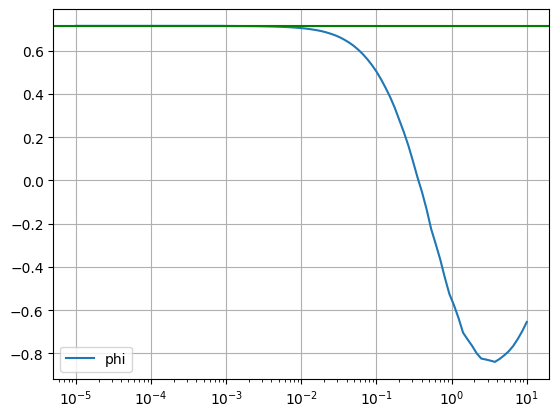

In [22]:
phi_rgint = RegularGridInterpolator((kk,kk,kk), phigrid, method='linear', bounds_error=False, fill_value=5/7)
xi_rgint = RegularGridInterpolator((kk,kk,kk), xigrid, method='linear', bounds_error=False,fill_value=2/7)

keval = np.logspace(-5,1,100)
# keval=kk

evals = [[k,1.e-3, 0.01] for k in keval]
plt.plot(keval, phi_rgint(evals), label='phi')
# plt.plot(keval, xi_rgint(evals), label='xi')

plt.xscale('log')
plt.axhline(y=5/7, color='g')
plt.legend()
plt.grid(True)
plt.show()

---
### Compute looop

In [17]:
def F2_phi(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    p2 = k2 + q2 - 2*k*q*mu 
    return 1/2*(1+k*mu/q+(k*q*mu-q2)/p2)

def F2_xi(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    p2 = k2 + q2 - 2*k*q*mu 
    return -1/2*((q2-k*q*mu)*(k2-2*k*q+2*k*q*mu))/q2/p2

def F2_EdS(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)


def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

In [26]:
import concurrent.futures

klist=np.logspace(-2,0,100)
# klist=[0.1]
# onelterm=np.zeros_like(klist)
eps=1.e-3
fx=0.3

def eval_one_loop(k):
    i=np.where(klist == k)
    # print('k='+str(k))
    qq = np.logspace(np.log10(eps),0.5,200)
    intgndq = np.zeros_like(qq)
    for i in range(len(qq)):
        q = qq[i]
        muu= np.linspace(-1.,1., 100) #occhio questo e un vettore eh
        # F3_val = F3(k,q,muu)
        # intgndmu = 6*q*q*F3_val*Pchi_int(q)*Pchi_int(k) #13 part
        intgndmu=0
        kMq = np.sqrt(k*k + q*q - 2*k*q*muu)
        mumask = kMq>q
        phixieval = [[k,q,p] for p in kMq]
        F2sq_val = F2_EdS(k,q,muu)*(phi_rgint(phixieval)*F2_phi(k,q,muu)+xi_rgint(phixieval)*F2_xi(k,q,muu))
        # F2sq_val = F2_EdS(k,q,muu)*(5/7*F2_phi(k,q,muu)+2/7*F2_xi(k,q,muu))
        tmp22 = 2*q*q*F2sq_val*Pchi_int(q)*Pchi_int(kMq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        kPq = np.sqrt(k*k + q*q + 2*k*q*muu) #22 part
        mumask = kPq>q
        phixieval = [[k,q, p] for p in kPq]
        F2sq_val = F2_EdS(k,q,-muu)*(phi_rgint(phixieval)*F2_phi(k,q,-muu)+xi_rgint(phixieval)*F2_xi(k,q,-muu))
        # F2sq_val = F2_EdS(k,q,-muu)*(5/7*F2_phi(k,q,-muu)+2/7*F2_xi(k,q,-muu))

        tmp22 = 2*q*q*F2sq_val*Pchi_int(q)*Pchi_int(kPq)
        tmp22[~mumask] = 0
        intgndmu += tmp22

        muintegral = simpson(intgndmu,muu)
        intgndq[i]=muintegral

    pintegral = simpson(intgndq,qq)*(2*np.pi)/fact
    return(pintegral)

with concurrent.futures.ProcessPoolExecutor() as executor:
    onelterm = executor.map(eval_one_loop, klist)
    
onelterm_withcorr = np.array(list(onelterm))
# onelterm_EdS = np.array(list(onelterm))


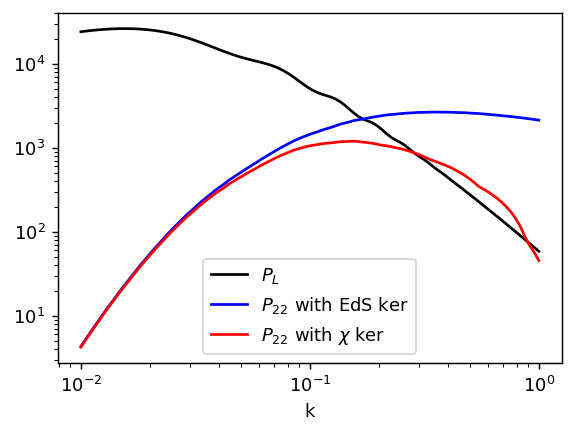

In [34]:
plt.figure(figsize=(5,3.5), dpi=130)
plt.plot(qq,Pchi_int(qq),'k',label=r'$P_{L}$')
plt.plot(klist,onelterm_EdS, 'b',label=r'$P_{22}$ with EdS ker')
plt.plot(klist,onelterm_withcorr, 'r',label=r'$P_{22}$ with $\chi$ ker')

qq = np.logspace(-2,0,100) 

# plt.plot(klist,Pchi_int(klist)+onelterm_withcorr,'k:',label=r'P nonlin')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower center')
plt.xlabel('k')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/chiker-22.pdf',bbox_inches='tight')

plt.show()